# Semantic Segmentation

##### 균열 데이터셋 다운로드

https://drive.google.com/file/d/1GiRp1tDU2znbOL366UpxLkDYoBQ37ziC/view?usp=sharing

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
# 데이터셋 다운로드
!gdown https://drive.google.com/uc?id=1GiRp1tDU2znbOL366UpxLkDYoBQ37ziC

Downloading...
From (original): https://drive.google.com/uc?id=1GiRp1tDU2znbOL366UpxLkDYoBQ37ziC
From (redirected): https://drive.google.com/uc?id=1GiRp1tDU2znbOL366UpxLkDYoBQ37ziC&confirm=t&uuid=c96bbd7c-a0ec-4b8b-bc76-bc17428998fe
To: /content/pavement_crack.zip
100% 2.13G/2.13G [00:38<00:00, 55.3MB/s]


In [ ]:
# 데이터셋 압축 해제
!unzip pavement_crack.zip

Streaming output truncated to the last 5000 lines.
  inflating: crack_segmentation_dataset/train/masks/CRACK500_20160222_165926_641_1.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2817_34_1828_3755_3708.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2838_547_1340_1856_2398.jpg  
  inflating: crack_segmentation_dataset/train/masks/Volker_DSC01695_806_127_1820_1549.jpg  
  inflating: crack_segmentation_dataset/train/masks/noncrack_noncrack_concrete_wall_12_7.jpg.jpg  
  inflating: crack_segmentation_dataset/train/masks/CRACK500_20160405_171456_1281_361.jpg  
  inflating: crack_segmentation_dataset/train/masks/Volker_DSC01706_240_1123_1495_1323.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2865_413_845_3382_2544.jpg  
  inflating: crack_segmentation_dataset/train/masks/CRACK500_20160405_171219_1_361.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Flo

**굵은 텍스트**#### UNET

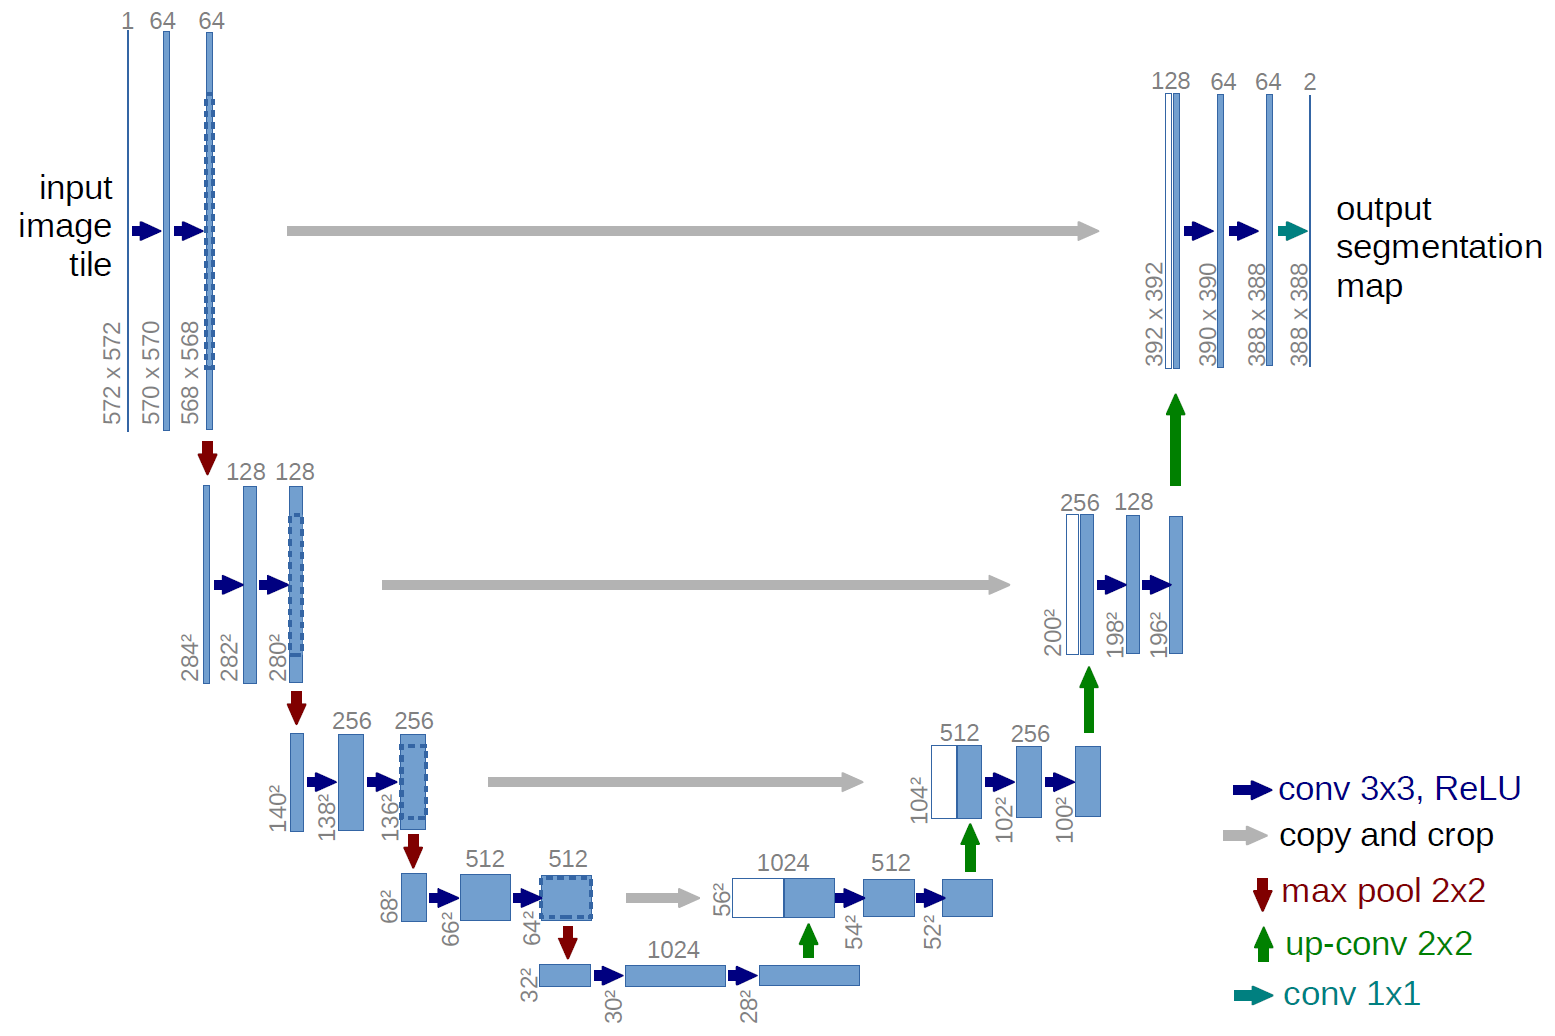

##### 필요 라이브러리 임포트

In [ ]:
# 라이브러리 임포트
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision.transforms as transforms

import os
import tqdm
import random
import shutil
import numpy as np
from PIL import Image
from pathlib import Path
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt

In [ ]:
# 재현성을 위한 랜덤시드 고정
random_seed = 2023
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

##### 균열 데이터 클래스 정의

In [ ]:
# 데이터 클래스 정의
class CrackDatasets(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform, mask_transform):
        self.img_dir = img_dir
        self.img_transform = img_transform
        self.img_files = []
        self.mask_dir = mask_dir
        self.mask_transform = mask_transform
        self.mask_files = []
        self.seed = np.random.randint(2023)

        for img_name in os.listdir(self.img_dir):
          if img_name.split('.')[-1] in ('png', 'jpg'):
            self.img_files.append(os.path.join(self.img_dir, img_name))
            self.mask_files.append(os.path.join(self.mask_dir, img_name))

    def __getitem__(self, i):
        img = Image.open(self.img_files[i])
        if self.img_transform is not None:
            random.seed(self.seed)
            img = self.img_transform(img)

        mask = Image.open(self.mask_files[i]).convert('L')
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return img, mask

    def __len__(self):
        return len(self.img_files)


##### Dice Score와 IoU 메트릭 함수 정의

In [ ]:
def dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()

def iou(y_true, y_pred, epsilon: float = 1e-6):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + epsilon) / (union + epsilon)

##### UNet 모델 클래스 정의

In [ ]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

##### 유틸 함수 정의

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def find_latest_model_path(dir):
    model_paths = []
    epochs = []
    for path in Path(dir).glob('*.pth'):
        if 'epoch' not in path.stem:
            continue
        model_paths.append(path)
        parts = path.stem.split('_')
        epoch = int(parts[-1])
        epochs.append(epoch)

    if len(epochs) > 0:
        epochs = np.array(epochs)
        max_idx = np.argmax(epochs)
        return model_paths[max_idx]
    else:
        return None

def save_check_point(state, is_best, file_name = 'checkpoint.pth'):
    torch.save(state, file_name)
    if is_best:
        shutil.copy(file_name, 'model_best.pth')

def calc_crack_pixel_weight(mask_dir):
    avg_w = 0.0
    n_files = 0
    for path in Path(mask_dir).glob('*.*'):
        n_files += 1
        m = ndimage.imread(path)
        ncrack = np.sum((m > 0)[:])
        w = float(ncrack)/(m.shape[0]*m.shape[1])
        avg_w = avg_w + (1-w)

    avg_w /= float(n_files)

    return avg_w / (1.0 - avg_w)

##### 학습 & 검증 함수 정의

In [ ]:
def train(train_loader, model, criterion, optimizer, valid_loader, model_dir, n_epoch, batch_size, lr, device):

    latest_model_path = find_latest_model_path(model_dir)

    best_model_path = os.path.join(*[model_dir, 'model_best.pth'])

    if latest_model_path is not None:
        state = torch.load(latest_model_path)
        epoch = state['epoch']
        model.load_state_dict(state['model'])
        epoch = epoch

        #if latest model path does exist, best_model_path should exists as well
        assert Path(best_model_path).exists() == True, f'best model path {best_model_path} does not exist'
        #load the min loss so far
        best_state = torch.load(latest_model_path)
        min_val_los = best_state['valid_loss']

        print(f'Restored model at epoch {epoch}. Min validation loss so far is : {min_val_los}')
        epoch += 1
        print(f'Started training model from epoch {epoch}')
    else:
        print('Started training model from epoch 0')
        epoch = 0
        min_val_los = 9999

    valid_losses = []
    for epoch in range(epoch, n_epoch):

        adjust_learning_rate(optimizer, epoch, lr)

        tq = tqdm.tqdm(total=(len(train_loader) * batch_size))
        tq.set_description(f'Epoch {epoch}')

        losses = AverageMeter()
        t_iou = 0
        t_dice = 0

        model.train()
        for i, (input, target) in enumerate(train_loader):
            input_var  = Variable(input).to(device)
            target_var = Variable(target).to(device)

            masks_pred = model(input_var)
            pred = F.sigmoid(masks_pred)
            target_mask = target_var

            pred[pred>0.5]=1
            pred[pred<=0.5]=0
            target_mask[target_mask>0.5]=1
            target_mask[target_mask<=0.5]=0

            masks_probs_flat = masks_pred.view(-1)
            true_masks_flat  = target_var.view(-1)

            loss = criterion(masks_probs_flat, true_masks_flat)
            losses.update(loss)
            tq.set_postfix(loss='{:.5f}'.format(losses.avg))
            tq.update(batch_size)

            t_dice += dice_coeff(pred, target_mask)
            t_iou += iou(pred, target_mask)

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'train miou : {t_iou/len(train_loader):.5f} train dice score : {t_dice/len(train_loader):.5f}')
        valid_metrics = valid(model, valid_loader, criterion)
        valid_loss = valid_metrics['valid_loss']
        valid_dice = valid_metrics['v_dice']
        valid_iou = valid_metrics['v_iou']
        valid_losses.append(valid_loss)
        print(f'valid_loss = {valid_loss:.5f}')
        print(f'valid miou : {valid_iou/len(valid_loader):.5f} valid dice score : {valid_dice/len(valid_loader):.5f}') # 여기서 len(train_loader)를 len(valid_loader)로 변경
        tq.close()

        #save the model of the current epoch
        epoch_model_path = os.path.join(*[model_dir, f'model_epoch_{epoch}.pth'])
        torch.save({
            'model': model.state_dict(),
            'epoch': epoch,
            'valid_loss': valid_loss,
            'train_loss': losses.avg
        }, epoch_model_path)

        if valid_loss < min_val_los:
            min_val_los = valid_loss

            torch.save({
                'model': model.state_dict(),
                'epoch': epoch,
                'valid_loss': valid_loss,
                'train_loss': losses.avg
            }, best_model_path)

def valid(model, val_loader, criterion):
    losses = AverageMeter()
    v_iou = 0
    v_dice = 0
    model.eval()
    with torch.no_grad():

        for i, (input, target) in enumerate(val_loader):
            input_var = Variable(input).to(device)
            target_var = Variable(target).to(device)

            output = model(input_var)
            loss = criterion(output, target_var)

            losses.update(loss.item(), input_var.size(0))

            pred = F.sigmoid(output)
            target_mask = target_var

            pred[pred>0.5]=1
            pred[pred<=0.5]=0
            target_mask[target_mask>0.5]=1
            target_mask[target_mask<=0.5]=0

            v_dice += dice_coeff(pred, target_mask)
            v_iou += iou(pred, target_mask)

    return {'valid_loss': losses.avg, 'v_dice': v_dice, 'v_iou': v_iou}

##### 파라미터 정의


In [ ]:
# 모델 저장 폴더
model_dir = './model_weights'
os.makedirs(model_dir, exist_ok=True)

# 데이터 저장 폴더
data_dir = '/content/crack_segmentation_dataset/train'
DIR_IMG  = os.path.join(data_dir, 'images')
DIR_MASK = os.path.join(data_dir, 'masks')

# Device 할당
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lr = 0.001
momentum = 0.9
weight_decay = 1e-4
batch_size = 8
num_workers = 2
n_epoch = 10

In [ ]:
# 모델 할당
model = UNet(num_classes=1)

# 옵티마이저 정의
optimizer = torch.optim.SGD(model.parameters(), lr,
                                momentum=momentum,
                                weight_decay=weight_decay)

# 손실함수 정의
criterion = nn.BCEWithLogitsLoss().to(device)

channel_means = [0.485, 0.456, 0.406]
channel_stds  = [0.229, 0.224, 0.225]
train_tfms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Resize(256),
                                     transforms.Normalize(channel_means, channel_stds)])

val_tfms = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize(256),
                                   transforms.Normalize(channel_means, channel_stds)])

mask_tfms = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(256)])

dataset = CrackDatasets(img_dir=DIR_IMG, img_transform=train_tfms, mask_dir=DIR_MASK, mask_transform=mask_tfms)
train_size = int(0.85*len(dataset))
valid_size = len(dataset) - train_size
# train / val 데이터셋 분할
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# 데이터로더
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=num_workers)

model.to(device)

# train(train_loader, model, criterion, optimizer, valid_loader, model_dir, n_epoch, batch_size, lr)
train(train_loader, model, criterion, optimizer, valid_loader, model_dir, n_epoch, batch_size, lr, device)

Started training model from epoch 0


Epoch 0: 100%|██████████| 8168/8168 [09:17<00:00, 15.69it/s, loss=0.19596]

train miou : 0.17250 train dice score : 0.22863


Epoch 0: 100%|██████████| 8168/8168 [09:55<00:00, 13.71it/s, loss=0.19596]

valid_loss = 0.10645
valid miou : 0.13855 valid dice score : 0.22322



Epoch 1: 100%|██████████| 8168/8168 [09:17<00:00, 15.85it/s, loss=0.09086]

train miou : 0.26513 train dice score : 0.33291


Epoch 1: 100%|██████████| 8168/8168 [09:56<00:00, 13.70it/s, loss=0.09086]

valid_loss = 0.09055
valid miou : 0.30013 valid dice score : 0.37208



Epoch 2: 100%|██████████| 8168/8168 [09:17<00:00, 15.84it/s, loss=0.08071]

train miou : 0.32604 train dice score : 0.40916


Epoch 2: 100%|██████████| 8168/8168 [09:56<00:00, 13.70it/s, loss=0.08071]

valid_loss = 0.08294
valid miou : 0.37056 valid dice score : 0.45166



Epoch 3: 100%|██████████| 8168/8168 [09:17<00:00, 15.80it/s, loss=0.07473]

train miou : 0.36372 train dice score : 0.45159


Epoch 3: 100%|██████████| 8168/8168 [09:56<00:00, 13.70it/s, loss=0.07473]

valid_loss = 0.07725
valid miou : 0.36147 valid dice score : 0.46616



Epoch 4: 100%|██████████| 8168/8168 [09:17<00:00, 15.91it/s, loss=0.06995]

train miou : 0.39403 train dice score : 0.48163


Epoch 4: 100%|██████████| 8168/8168 [09:56<00:00, 13.70it/s, loss=0.06995]

valid_loss = 0.07510
valid miou : 0.42545 valid dice score : 0.52304



Epoch 5: 100%|██████████| 8168/8168 [09:17<00:00, 15.84it/s, loss=0.06682]

train miou : 0.41214 train dice score : 0.50955


Epoch 5: 100%|██████████| 8168/8168 [09:55<00:00, 13.71it/s, loss=0.06682]

valid_loss = 0.06816
valid miou : 0.44453 valid dice score : 0.55184



Epoch 6: 100%|██████████| 8168/8168 [09:17<00:00, 15.86it/s, loss=0.06414]

train miou : 0.43220 train dice score : 0.52842


Epoch 6: 100%|██████████| 8168/8168 [09:55<00:00, 13.70it/s, loss=0.06414]

valid_loss = 0.06869
valid miou : 0.42231 valid dice score : 0.53273



Epoch 7: 100%|██████████| 8168/8168 [09:18<00:00, 15.83it/s, loss=0.06218]

train miou : 0.44256 train dice score : 0.54189


Epoch 7: 100%|██████████| 8168/8168 [09:56<00:00, 13.69it/s, loss=0.06218]

valid_loss = 0.06742
valid miou : 0.43846 valid dice score : 0.54382



Epoch 8: 100%|██████████| 8168/8168 [09:17<00:00, 15.83it/s, loss=0.06027]

train miou : 0.45573 train dice score : 0.55740


Epoch 8: 100%|██████████| 8168/8168 [09:55<00:00, 13.71it/s, loss=0.06027]

valid_loss = 0.06268
valid miou : 0.49005 valid dice score : 0.58088



Epoch 9: 100%|██████████| 8168/8168 [09:17<00:00, 15.80it/s, loss=0.05830]

train miou : 0.46613 train dice score : 0.56859


Epoch 9: 100%|██████████| 8168/8168 [09:56<00:00, 13.70it/s, loss=0.05830]

valid_loss = 0.06200
valid miou : 0.48638 valid dice score : 0.58475


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

Training 그래프 시각화

[PosixPath('/content/model_weights/model_best.pth'), PosixPath('/content/model_weights/model_epoch_0.pth'), PosixPath('/content/model_weights/model_epoch_1.pth'), PosixPath('/content/model_weights/model_epoch_2.pth'), PosixPath('/content/model_weights/model_epoch_3.pth'), PosixPath('/content/model_weights/model_epoch_4.pth'), PosixPath('/content/model_weights/model_epoch_5.pth'), PosixPath('/content/model_weights/model_epoch_6.pth'), PosixPath('/content/model_weights/model_epoch_7.pth'), PosixPath('/content/model_weights/model_epoch_8.pth'), PosixPath('/content/model_weights/model_epoch_9.pth')]


<ipython-input-14-a9170fe0800a>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(w_path)


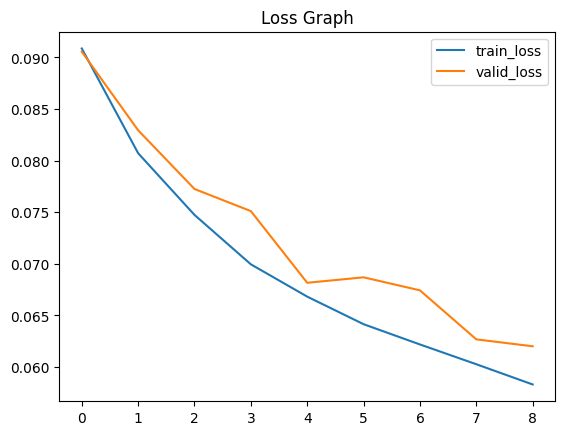

In [ ]:
# 저장된 모델 웨이트 경로 지정
model_dir = "/content/model_weights"
title = "Loss Graph"

weights_paths = [path for path in Path(model_dir).glob('*.pth')]
weights_paths = sorted(weights_paths)
print(weights_paths)
epochs = []
tr_losses = []
vl_losses = []
for w_path in weights_paths:
    if 'epoch' not in w_path.stem:
        continue
    #load the min loss so far
    parts = w_path.stem.split('_')
    epoch = int(parts[-1])
    epochs.append(epoch)
    state = torch.load(w_path)
    val_los = state['valid_loss']
    train_loss = float(state['train_loss'])
    tr_losses.append(train_loss)
    vl_losses.append(val_los)
sorted_idxs = np.argsort(epochs)
tr_losses = [tr_losses[idx] for idx in sorted_idxs]
vl_losses = [vl_losses[idx] for idx in sorted_idxs]
plt.plot(tr_losses[1:], label='train_loss')
plt.plot(vl_losses[1:], label='valid_loss')
plt.title(title)
plt.legend()
plt.show()

##### 성능 평가 메소드

In [ ]:
import cv2
def evaluate(test_loader, model, output_path):
    e_iou = 0
    e_dice = 0
    model.eval()
    with torch.no_grad():
        for i, (input, target) in enumerate(test_loader):
            input_var = Variable(input).to(device)
            target_var = Variable(target).to(device)

            output = model(input_var)
            pred = F.sigmoid(output)
            target_mask = target_var

            pred[pred>0.5]=1
            pred[pred<=0.5]=0
            target_mask[target_mask>0.5]=1
            target_mask[target_mask<=0.5]=0

            cv2.imwrite(f'{output_path}/predicts/{i}.png', tensor2image(pred))
            cv2.imwrite(f'{output_path}/masks/{i}.png', tensor2image(target_mask))

            e_dice += dice_coeff(pred, target_mask)
            e_iou += iou(pred, target_mask)

    print(f'test miou : {e_iou/len(test_loader):.5f} test dice score : {e_dice/len(test_loader):.5f}')

In [ ]:
def denormalize(image):
    # IMAGENET_MEAN, IMAGENET_STD = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    # image = np.clip(255.0 * (image * IMAGENET_STD + IMAGENET_MEAN), 0, 255)
    image = image * 255.0
    return image

def tensor2image(tensor_list):
    img = tensor_list[0].detach().cpu().numpy() # tensor -> numpy
    img = np.transpose(img, (1, 2, 0)) # [C,H,W] -> [H,W,C]
    img = denormalize(img) # *255 or IMAGENET denorm 방법
    # img = img.astype('float32')
    # img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # Gray 채널
    img = img.astype(np.uint8).copy() # np.float32 -> np.uint8
    return img

In [ ]:
# 테스트 데이터셋
test_data_dir = '/content/crack_segmentation_dataset/test'
test_img_path  = os.path.join(test_data_dir, 'images')
test_mask_path = os.path.join(test_data_dir, 'masks')

test_tfms = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(channel_means, channel_stds)])

mask_tfms = transforms.Compose([transforms.ToTensor()])

test_dataset = CrackDatasets(img_dir=test_img_path, img_transform=test_tfms, mask_dir=test_mask_path, mask_transform=mask_tfms)
test_loader = DataLoader(test_dataset, 1, shuffle=False, num_workers=num_workers)

# 모델 할당
model = UNet(num_classes=1)

best_model_path = os.path.join(*[model_dir, 'model_best.pth'])
if best_model_path is not None:
    state = torch.load(best_model_path)
    epoch = state['epoch']
    model.load_state_dict(state['model'])
model.to(device)

# 결과물 저장 폴더 생성
os.makedirs('/content/results/predicts', exist_ok=True)
os.makedirs('/content/results/masks', exist_ok=True)

output_path = '/content/results'
evaluate(test_loader, model, output_path)

<ipython-input-17-39ac5d5da630>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(best_model_path)


test miou : 0.36548 test dice score : 0.48618


#### 커스텀 데이터 다운로드

https://drive.google.com/file/d/1g9Sa5XF6Ps0X5dTnZ9TR81iJSe8wcJEp/view?usp=share_link

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown https://drive.google.com/uc?id=1g9Sa5XF6Ps0X5dTnZ9TR81iJSe8wcJEp

Downloading...
From: https://drive.google.com/uc?id=1g9Sa5XF6Ps0X5dTnZ9TR81iJSe8wcJEp
To: /content/Semantic_Custom_Datasets.zip
100% 456k/456k [00:00<00:00, 124MB/s]


In [ ]:
!unzip /content/Semantic_Custom_Datasets.zip

Archive:  /content/Semantic_Custom_Datasets.zip
   creating: Semantic_Custom_Datasets/
  inflating: Semantic_Custom_Datasets/.DS_Store  
  inflating: __MACOSX/Semantic_Custom_Datasets/._.DS_Store  
   creating: Semantic_Custom_Datasets/images/
   creating: Semantic_Custom_Datasets/masks/
  inflating: Semantic_Custom_Datasets/images/CRACK500_20160222_080933_361_1.jpg  
  inflating: __MACOSX/Semantic_Custom_Datasets/images/._CRACK500_20160222_080933_361_1.jpg  
  inflating: Semantic_Custom_Datasets/images/CFD_007.jpg  
  inflating: __MACOSX/Semantic_Custom_Datasets/images/._CFD_007.jpg  
  inflating: Semantic_Custom_Datasets/images/CFD_001.jpg  
  inflating: __MACOSX/Semantic_Custom_Datasets/images/._CFD_001.jpg  
  inflating: Semantic_Custom_Datasets/images/CRACK500_20160222_115224_1281_1081.jpg  
  inflating: __MACOSX/Semantic_Custom_Datasets/images/._CRACK500_20160222_115224_1281_1081.jpg  
  inflating: Semantic_Custom_Datasets/images/CFD_109.jpg  
  inflating: __MACOSX/Semantic_Custo

##### CVAT 마스크 라벨 포맷 변형

.png -> .jpg

In [ ]:
from PIL import Image
root_dir = '/content/Semantic_Custom_Datasets/masks'
for img in os.listdir(root_dir):
  if img.split('.')[-1] in ('png', 'jpg'):
    im = Image.open(os.path.join(root_dir, img))
    im.save(os.path.join(root_dir, img.split('.')[0]+'.jpg'))
    os.remove(os.path.join(root_dir, img))

##### 커스텀 데이터셋 성능평가

In [ ]:
test_data_dir = '/content/Semantic_Custom_Datasets'
test_img_path  = os.path.join(test_data_dir, 'images')
test_mask_path = os.path.join(test_data_dir, 'masks')

test_tfms = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(channel_means, channel_stds)])

mask_tfms = transforms.Compose([transforms.ToTensor()])

test_dataset = CrackDatasets(img_dir=test_img_path, img_transform=test_tfms, mask_dir=test_mask_path, mask_transform=mask_tfms)
test_loader = DataLoader(test_dataset, 1, shuffle=False, num_workers=num_workers)

# 모델 할당
model = UNet(num_classes=1)

best_model_path = os.path.join(*[model_dir, 'model_best.pth'])
if best_model_path is not None:
    state = torch.load(best_model_path)
    epoch = state['epoch']
    model.load_state_dict(state['model'])
model.to(device)

# 결과물 저장 폴더 생성
os.makedirs('/content/custom_results/predicts', exist_ok=True)
os.makedirs('/content/custom_results/masks', exist_ok=True)

output_path = '/content/custom_results'
evaluate(test_loader, model, output_path)

<ipython-input-21-9b7e39960393>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(best_model_path)


test miou : 0.52938 test dice score : 0.68813
